In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from concept_erasure import LeaceEraser

## Two classes

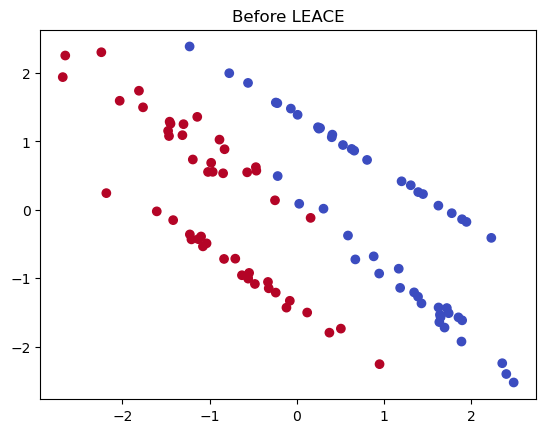

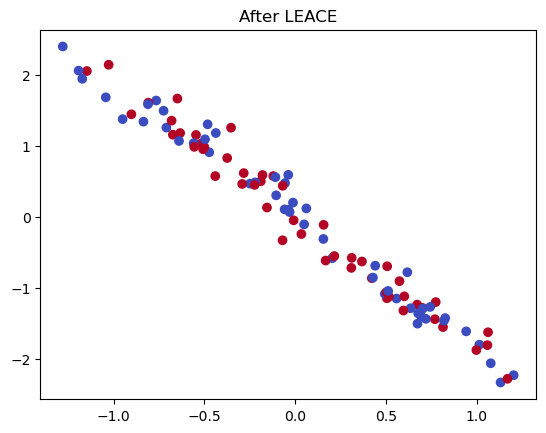

In [30]:
n, d, k = 100, 10, 2

X, Y = make_classification(
    n_samples=n,
    n_features=d,
    n_classes=k,
    random_state=42,
)
X_t = torch.from_numpy(X)
Y_t = torch.from_numpy(Y)

# Logistic regression does learn something before concept erasure
real_lr = LogisticRegression(max_iter=1000).fit(X, Y)
beta = torch.from_numpy(real_lr.coef_)
assert beta.norm(p=torch.inf) > 0.1

eraser = LeaceEraser.fit(X_t, Y_t)
X_ = eraser(X_t)

plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
plt.title("Before LEACE")
plt.show()

plt.scatter(X_[:, 0], X_[:, 1], c=Y, cmap='coolwarm')
plt.title("After LEACE")
plt.show()

In [31]:
probe = LogisticRegression().fit(X, Y) 

acc_before = probe.score(X, Y)
print(f"Probe accuracy BEFORE LEACE (on test set): {acc_before:.2f}")

probe_after = LogisticRegression(max_iter=1000).fit(X_, Y)
acc_after = probe_after.score(X_, Y)
print(f"Probe accuracy AFTER LEACE (on test set): {acc_after:.2f}")

Probe accuracy BEFORE LEACE (on test set): 1.00
Probe accuracy AFTER LEACE (on test set): 0.50
